In [1]:
import sympy as sy

from sympy.solvers.ode.systems import dsolve_system

import numpy as np
from scipy.integrate import solve_ivp

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# !pip install sympy

In [4]:
sy.init_printing()

## Balisticka křivka

Rovnice pohubu tělesa v gravitačním poli Země:

$$ \ddot x = 0 + F^x_\text{od}(\dot x, \dot y) $$
$$ \ddot y = -g + F^y_\text{od}(\dot x, \dot y) $$

Počateční podmínky (např.):

$$ v_0 = 10 \,\text{m/s}, \alpha_0 = 45 \deg $$
$$ x(t = 0) = 0;  y(t = 0) = 100 \mathrm{m} $$

### Úkoly:

Řeště pohybovou rovnici pro těleso v gravitačním poli Země
- bez odporu vzduchu,
- s lineárním odporem vzduchu,
- s kvadratickým odporem vzduchu.

Řešte pomocí SymPy a numericky pomocí SciPy a NumPy.

### Parametry:

#### Podúkoly:

1. Najděte řešení rovnic pohyby.
2. Zjistětě kdy těleso dopadne na zem ($y = 0$).
3. Najěte optimální úhel výstřelu pro maximální dolet. 
4. Vykreslete trajektorii tělesa. 


## Bez odporu vzduchu:

$$F_{\text{od}} = 0$$

### SymPy

#### Úkol 1: Najděte řešení rovnic pohybu.

In [5]:

# Tyto symboly budou použity pro definici funkcí
x, y, v = sy.symbols("x y v", cls=sy.Function)
# Omezením na reálné a kladné hodnoty omezím prostor řešení
k, g, m, t = sy.symbols("k, g, m, t", real=True, positive=True)
# Počáteční podmínky
v0, alpha, y0 = sy.symbols("v_0, alpha, y_0")

alpha

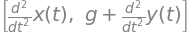

In [6]:
# System rovnic k řešení
eq_x = x(t).diff((t ,2))
eq_y = y(t).diff((t, 2)) + g

system = [eq_x, eq_y]

system

In [7]:
# Počateční podmínky
ics = {
    x(0): 0, y(0): y0, 
    x(t).diff(t).subs(t, 0): v0 * sy.cos(alpha),
    y(t).diff(t).subs(t, 0): v0 * sy.sin(alpha),
}

ics

In [8]:
# Pro lepší porozumění si to můžeme zobrazit
x(t).diff(t)

In [9]:
x(t).diff(t).subs(t, 0)

In [10]:
# Pro nalezení řešení použijeme funkci `dsolve`
sol= sy.dsolve(system, ics = ics)
sol

Řešením je, nepřekvapivě, parametricky vyjádřená parabola.

#### Úkol 2: Zjistětě kdy těleso dopadne na zem ($y = 0$).

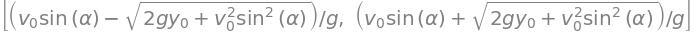

In [11]:
t_touches = sy.solve(sol[1].rhs, t)
t_touches

Vidíme, že mame dvě řešní, pohledem je patrné, že nás zajímá druhé řešení

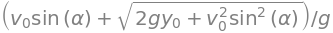

In [12]:
t_touch = t_touches[-1]
t_touch

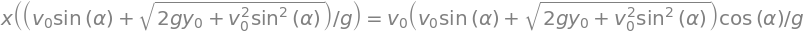

In [13]:
x_max = sol[0].subs(t, t_touch)
x_max

#### Úkol 3: Najěte optimální úhel výstřelu pro maximální dolet.

Z rovnice pro dolet $x_{\text{max}}$ můžeme získat optimální úhel výstřelu $\alpha_{\text{opt}}$ pomocí derivace $x_{\text{max}}$ podle $\alpha$.

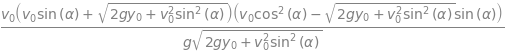

In [14]:
dxmaxdalpha = sy.simplify(sy.diff(x_max.rhs, alpha))
dxmaxdalpha

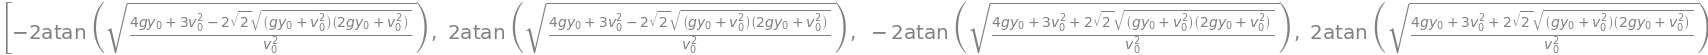

In [15]:
alpha_opts = sy.solve(dxmaxdalpha, alpha)
alpha_opts

Tady už to začíná být zajímavé. Pojďme si to vyhodnotit pro nějaké konkrétní hodnoty, zde pro $y_0 = 0$.

In [16]:
[180 / np.pi * alpha.subs({v0: 100, y0: 0, g: 9.81}).evalf() for alpha in alpha_opts]

Okamžitě vidíme, že nas zajíma pouze druhé řešení. Pro zajímavost si můžeme zobrazit závislost $x_{\text{max}}$ na $\alpha$.

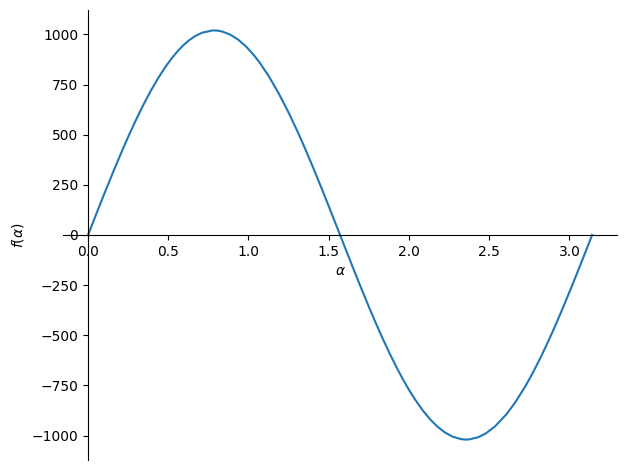

In [17]:
# Plot x_max as a function of alpha:
sy.plot(x_max.rhs.subs({v0: 100, y0: 0, g: 9.81}), (alpha, 0, np.pi))

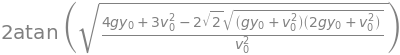

In [18]:
alpha_opt = alpha_opts[1]
alpha_opt

Vykresleme si tento úhel pro různé hodnoty $y_0$.



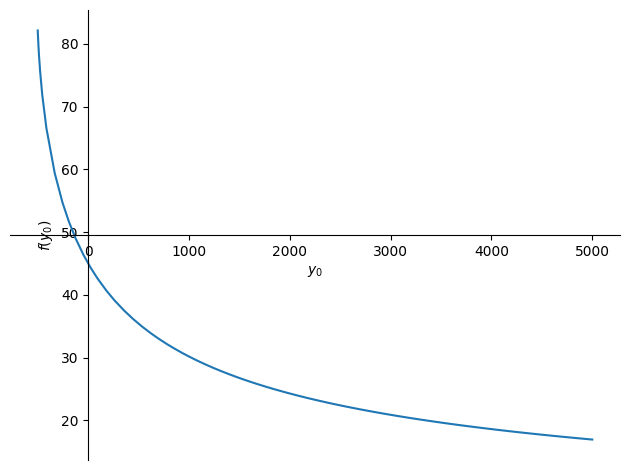

In [19]:
sy.plot(alpha_opt.subs({v0: 100, g: 9.81}) * 180 / sy.pi, (y0, -500, 5000))

#### Úkol 4: Vykreslete trajektorii tělesa.

In [20]:
# Boundary conditions:
v0_ = 50
y0_ = 100
g_ = 9.81


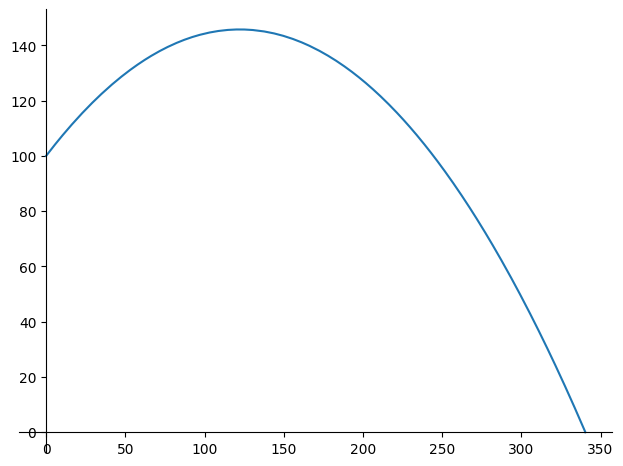

In [21]:
sy.plot_parametric(sol[0].rhs.subs({v0: v0_, alpha: alpha_opt, y0: y0_, g: g_}), 
                   sol[1].rhs.subs({v0: v0_, alpha: alpha_opt, y0: y0_, g: g_}), 
                   (t, 0, t_touch.subs({v0: v0_, alpha: alpha_opt, y0: y0_, g: g_})))


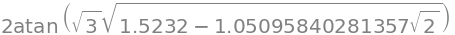

In [22]:
alpha_opt_eval = alpha_opt.subs({v0: v0_, y0: y0_, g: g_})
alpha_opt_eval

#### Bonus: Numerické vyhodnocení analytického řešení

In [23]:
alpha_opt_eval = float(alpha_opt.subs({v0: v0_, y0: y0_, g: g_}))
alpha_opt_eval

In [24]:

t_opt_eval = float(t_touch.subs({v0: v0_, alpha: alpha_opt_eval, y0: y0_, g: g_}))
t_opt_eval

In [25]:
# Definujme si funkce pro x(t, alpha) a y(t, alpha)
x_func = sy.lambdify((t, alpha), sol[0].rhs.subs({v0: v0_, y0: y0_, g: g_}), "numpy")
y_func = sy.lambdify((t, alpha), sol[1].rhs.subs({v0: v0_, y0: y0_, g: g_}), "numpy")
y_func

<function _lambdifygenerated(t, alpha)>

In [26]:
# Evaluate the function for a range of t
t_vals = np.linspace(0, t_opt_eval, 100)
x_vals = x_func(t_vals, alpha_opt_eval)
y_vals = y_func(t_vals, alpha_opt_eval)

In [27]:
# Pro později si definujme funkce pro x(t, alpha, v0, y0, g)
funx_noair_allargs = sy.lambdify([t, v0, alpha, y0], sol[0].rhs.subs({g: g_}), "numpy")
funy_noair_allargs = sy.lambdify([t, v0, alpha, y0], sol[1].rhs.subs({g: g_}), "numpy")

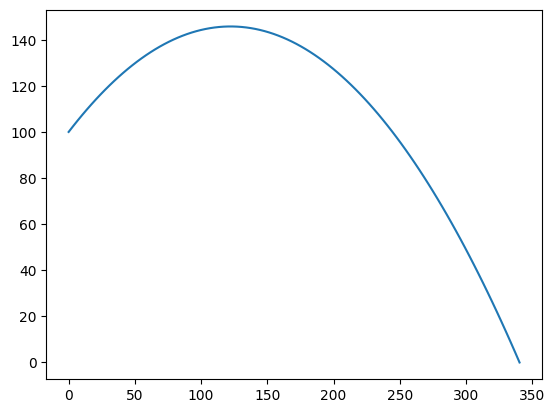

In [28]:
fig, ax = plt.subplots()
# ax.plot(funxnp(t_vals), funynp(t_vals))
ax.plot(x_vals, y_vals)

### Numerické řešení pomocí SciPy `integrate.solve_ivp`

Using the `solve_ivp` function from the `scipy.integrate` module.

#### Úkol 1: Najděte řešení rovnic pohybu

Nejdříve musíme redukovat rovnici druhého řádu na soustavu dvou rovnic prvního řádu

\begin{align}
\dot x &= v_x \\
\dot v_x &= 0 \\
\dot y &= v_y \\
\dot v_y &= -g
\end{align}

In [29]:
# Musíme zadat i hodnotu odporu vzduchu, jelikož nemame matematický model jako v předchozím případě.
alpha_ = np.pi / 4 

In [30]:
def rhs(t, y):
    x, v_x, y, v_y = y
    return [v_x, 0, v_y, -g_]

t_vals = np.linspace(0, 10, 100)
y_init = [0, v0_ * np.cos(alpha_), y0_, v0_ * np.sin(alpha_)]

sol = solve_ivp(rhs, [0, 10], y_init, t_eval=t_vals)
# sol = solve_ivp(rhs, [0.01, 10], y_init, t_eval=t_vals)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.010e-01 ...  9.899e+00  1.000e+01]
        y: [[ 0.000e+00  3.571e+00 ...  3.500e+02  3.536e+02]
            [ 3.536e+01  3.536e+01 ...  3.536e+01  3.536e+01]
            [ 1.000e+02  1.035e+02 ... -3.066e+01 -3.695e+01]
            [ 3.536e+01  3.436e+01 ... -6.175e+01 -6.274e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 44
     njev: 0
      nlu: 0

#### Vykresleme si trajektorii a porovnejme s analytickým řešením:

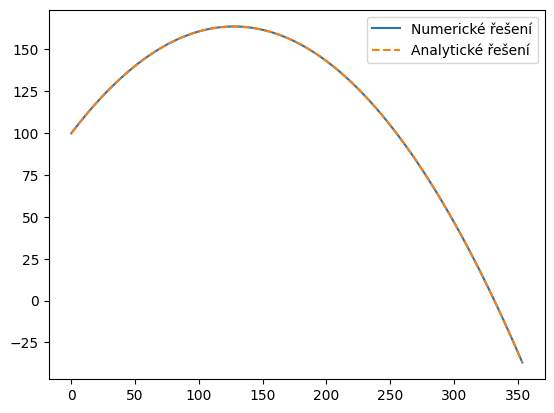

In [31]:

fig, ax = plt.subplots()
ax.plot(sol.y[0], sol.y[2], label="Numerické řešení")
ax.plot(x_func(t_vals, alpha_), y_func(t_vals, alpha_), "--", label="Analytické řešení")
ax.legend()

Řešení máme, zdá se, správné. Nicméně, jsme přestřelili zem. 

#### Úkol 2: Zjistětě kdy těleso dopadne na zem ($y = 0$).

Naštěstí metoda `solve_ivp` umožňuje definovat tzv. *events*, tedy události, které se mají stát v průběhu řešení. V našem případě nás zajímá, kdy těleso dopadne na zem, tedy kdy $y = 0$.

In [32]:
def hit_ground_event(t, y):
    return y[2]

# Při pohledu do dokumentace, zjistíme, že je potřeba nastavit atribut `terminal` na `True`, aby se řešení zastavilo, když těleso dopadne na zem.
hit_ground_event.terminal = True

# Zajíma nas pouze, kdy těleso dopadne na zem shora
hit_ground_event.direction = -1

In [33]:
sol = solve_ivp(rhs, [0, 100], y_init, t_eval=t_vals, events=hit_ground_event)
sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  1.010e-01 ...  9.192e+00  9.293e+00]
        y: [[ 0.000e+00  3.571e+00 ...  3.250e+02  3.286e+02]
            [ 3.536e+01  3.536e+01 ...  3.536e+01  3.536e+01]
            [ 1.000e+02  1.035e+02 ...  1.055e+01  4.966e+00]
            [ 3.536e+01  3.436e+01 ... -5.482e+01 -5.581e+01]]
      sol: None
 t_events: [array([ 9.381e+00])]
 y_events: [array([[ 3.317e+02,  3.536e+01, -2.842e-14, -5.667e+01]])]
     nfev: 44
     njev: 0
      nlu: 0

In [34]:
t_touch = sol.t_events[0]

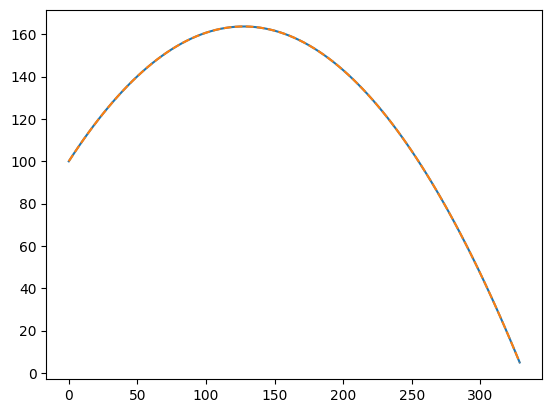

In [35]:

# Plot the results

fig, ax = plt.subplots()
ax.plot(sol.y[0], sol.y[2])
ax.plot(x_func(sol.t, alpha_), y_func(sol.t, alpha_), "--", label="Analytické řešení")

#### Úkol 3: Najěte optimální úhel výstřelu pro maximální dolet.

Pro numerické optimalizace můžeme použít knihovnu SciPy, konkrétně funkci `scipy.optimize.minimize_scalar`. 
Abychom mohli tuto funkci použít, musíme definovat funkci, kterou chceme minimalizovat. V našem případě chceme maximalizovat dolet, tedy $x_{\text{max}}$.
Pro získaní doletu musíme ovšem již numericky řešit rovnici pohybu.

In [36]:
from scipy.optimize import minimize_scalar
minimize_scalar?

Signature:
minimize_scalar(
    fun,
    bracket=None,
    bounds=None,
    args=(),
    method=None,
    tol=None,
    options=None,
)
Docstring:
Local minimization of scalar function of one variable.

Parameters
----------
fun : callable
    Objective function.
    Scalar function, must return a scalar.
bracket : sequence, optional
    For methods 'brent' and 'golden', `bracket` defines the bracketing
    interval and is required.
    Either a triple ``(xa, xb, xc)`` satisfying ``xa < xb < xc`` and
    ``func(xb) < func(xa) and  func(xb) < func(xc)``, or a pair
    ``(xa, xb)`` to be used as initial points for a downhill bracket search
    (see `scipy.optimize.bracket`).
    The minimizer ``res.x`` will not necessarily satisfy
    ``xa <= res.x <= xb``.
bounds : sequence, optional
    For method 'bounded', `bounds` is mandatory and must have two finite
    items corresponding to the optimization bounds.
args : tuple, optional
    Extra arguments passed to the objective function.
meth

In [37]:
def dolet(alpha, v0, y0):
    alpha = alpha
    y_init = [0, v0 * np.cos(alpha), y0, v0 * np.sin(alpha)]
    
    sol = solve_ivp(rhs, [1e-5, 1000], y_init,  events=hit_ground_event)
    # Pro připomenutí vektor y je [x, v_x, y, v_y]
    return sol.t_events[0][0], sol.y_events[0][0]

In [38]:
# POZOR na minus - minimalizujeme zápornou hodnotu doletu
min_func = lambda alpha: -dolet(alpha, v0_, y0_)[1][0]

res = minimize_scalar(min_func, bounds=(0, np.pi / 2), method="bounded")
res

 message: Solution found.
 success: True
  status: 0
     fun: -340.45975315320493
       x: 0.6425552756574062
     nit: 10
    nfev: 10

In [39]:
# Nyní můžeme formulovat funkci, která nám vrátí optimální úhel výstřelu pro maximální dolet.
def find_optimal_angle(v0, y0):
    min_func = lambda alpha: -dolet(alpha, v0, y0)[1][0]
    res = minimize_scalar(min_func, bounds=(0, np.pi / 2), method="bounded")
    return res.x

In [40]:
# Pro kontrolu, jak to vyjde s y0 = 0, z toho by měl být úhel 45 stupňů
find_optimal_angle(100, 0) * 180 / np.pi

## Linear response to air resistance

$$F_{\text{res}} = k v$$

$$
F = m \ddot x
$$

$$
m = 10\,\text{kg}, k \approx 0.3
$$

In [41]:
m_ = 10
k_ = 0.3

### SymPy

##### Úkol 1: Najděte řešení rovnic pohybu.

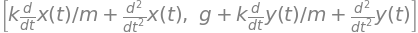

In [42]:
eq_x = x(t).diff((t ,2)) + (k / m) * x(t).diff(t)
eq_y = y(t).diff((t, 2)) + (k / m) * y(t).diff(t) + g

system = [eq_x, eq_y]
system

In [43]:
# Počateční podmínky jsou stejné jako v předchozím případě
ics

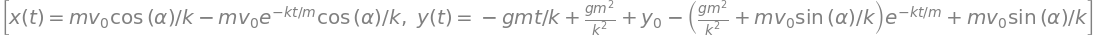

In [44]:
sol = sy.dsolve(system, ics = ics)
sol

In [45]:
g

#### Úkol 1.1: Numerické vyhodnocení:

In [46]:
funx_lin_allargs = sy.lambdify([t, v0, alpha, y0, k, m], sol[0].subs({g: g_}).rhs, "numpy")
funy_lin_allargs = sy.lambdify([t, v0, alpha, y0, k, m], sol[1].subs({g: g_}).rhs, "numpy")

funy_lin_allargs

<function _lambdifygenerated(t, v_0, alpha, y_0, k, m)>

In [47]:
#### Úkol 2: Zjistětě kdy těleso dopadne na zem ($y = 0$).

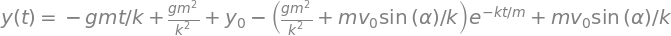

In [48]:
funy = sol[1]
funy

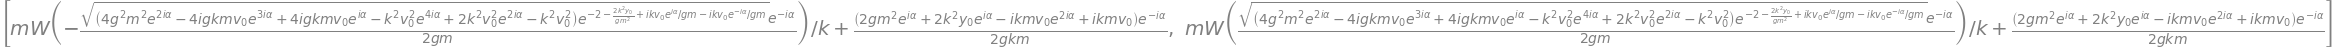

In [49]:
# Musíme zde změnit nastavení, abychom dostali řešení v rozumném čase:
t_touches = sy.solve(funy.rhs, t, simplify=False, check=False)
t_touches

Ok, tohle je zase zajímavé. Zkusme si to vyhodnotit pro nějaké konkrétní hodnoty.

In [50]:
[t.subs({v0: 100, alpha: np.pi / 4, y0: 0, g: 9.81, k: 0.1, m: 1}).evalf() for t in t_touches]

Tak tady jsme se dostali do problémů, můžete zkusit si rovnicí hrat, dosadit konkrétní hodnoty, či  zkusit Taylorovu expanzi.

Autor tohoto textu se nicméně moc daleko nedostal.

Zkusíme to tedy numericky. 

In [51]:
# sy.solve(funy.rhs.subs(
#     {k: k_, m: m_, g: g_}), t, simplify=False, check=False
# )

### Numerické řešení pomocí SciPy `integrate.solve_ivp`
#### Úkol 1 + 2

Rozložení do soustavy rovnic prvního řádu je podobné jako v předchozím případě.

\begin{align}
\dot x &= v_x \\
\dot v_x &= -\frac{k}{m} v_x \\
\dot y &= v_y \\
\dot v_y &= -g - \frac{k}{m} v_y
\end{align}


In [52]:
def rhs(t, y):
    x, v_x, y, v_y = y
    return [v_x, -k_ / m_ * v_x, v_y, -g_ - k_ / m_ * v_y]


t_vals = np.linspace(0, 100, 100)
y_init = [0, v0_ * np.cos(alpha_), y0_, v0_ * np.sin(alpha_)]

sol = solve_ivp(rhs, [0, 100], y_init, t_eval=t_vals, events=hit_ground_event)
sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  1.010e+00  2.020e+00  3.030e+00  4.040e+00
             5.051e+00  6.061e+00  7.071e+00  8.081e+00  9.091e+00]
        y: [[ 0.000e+00  3.518e+01 ...  2.537e+02  2.813e+02]
            [ 3.536e+01  3.430e+01 ...  2.774e+01  2.692e+01]
            [ 1.000e+02  1.302e+02 ...  5.784e+01  1.046e+01]
            [ 3.536e+01  2.454e+01 ... -4.265e+01 -5.114e+01]]
      sol: None
 t_events: [array([ 9.292e+00])]
 y_events: [array([[ 2.867e+02,  2.675e+01,  0.000e+00, -5.280e+01]])]
     nfev: 44
     njev: 0
      nlu: 0

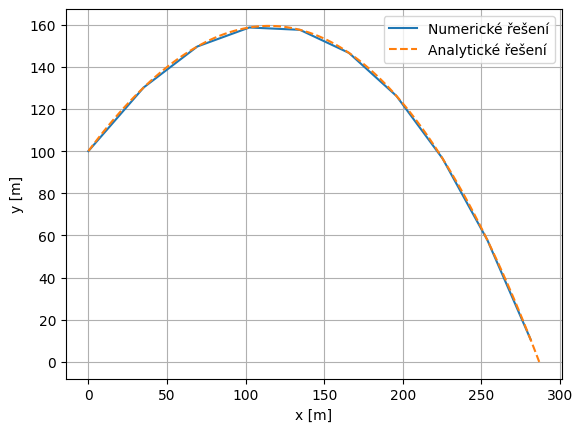

In [53]:
# Jak nam to dopadlo?
t_vals = np.linspace(0, sol.t_events[0][0], 100)

fig, ax = plt.subplots()

ax.plot(sol.y[0], sol.y[2], label="Numerické řešení")
ax.plot(funx_lin_allargs(t_vals, v0_, alpha_, y0_, k_, m_), 
        funy_lin_allargs(t_vals, v0_, alpha_, y0_, k_, m_), "--", label="Analytické řešení")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

ax.grid(True)
ax.legend() 

#### Úkol 3: Najěte optimální úhel výstřelu pro maximální dolet.

In [54]:
def dolet_linear(alpha, v0, y0, k, m):
    y_init = [0, v0 * np.cos(alpha), y0, v0 * np.sin(alpha)]
    
    def rhs(t, y):
        x, v_x, y, v_y = y
        return [v_x, -k / m * v_x, v_y, -g_ - k / m * v_y]
    
    sol = solve_ivp(rhs, [0, 1000], y_init, events=hit_ground_event)
    return sol.t_events[0][0], sol.y_events[0][0]

def find_optimal_angle_lin_response(v0, y0, k, m):
    # Zase pozor na minus (!)
    min_func = lambda alpha: -dolet_linear(alpha, v0, y0, k, m)[1][0]
    res = minimize_scalar(min_func, bounds=(0, np.pi / 2), method="bounded")
    return res.x

In [55]:
dolet_linear(np.pi / 4, 100, 0, 0.1, 1)

(12.051984682157133,
 array([495.23652336,  21.18702578,   0.        , -47.51929161]))

Zkusme si to nyní vizualizovat pro různé hodnoty $y_0$ a $k$.

In [56]:
# Aby se nam s tím lépe pracovalo, funkci nejdříve vektorizujeme
find_optimal_angle_lin_response = np.vectorize(find_optimal_angle_lin_response)


Nejdříve provedeme sken pro různé hodnoty $k$ s $y_0 = 0$

In [57]:
k_vals = np.linspace(0, 1, 100)

alpha_opt_vals = find_optimal_angle_lin_response(100, 0, k_vals, 1)

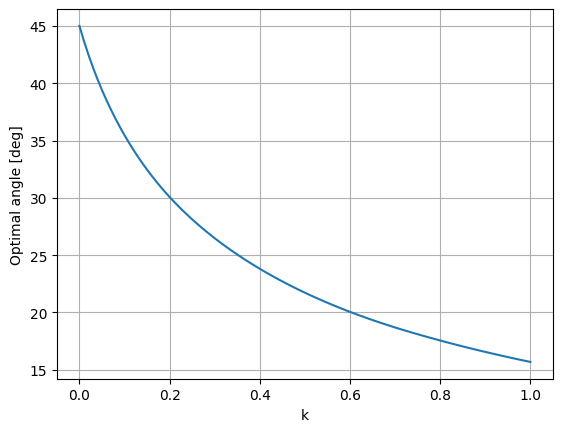

In [58]:
fig, ax = plt.subplots()
ax.plot(k_vals, alpha_opt_vals * 180 / np.pi)
ax.set_xlabel("k")
ax.set_ylabel("Optimal angle [deg]")
ax.grid(True)


Nyní provedeme sken pro různé hodnoty $y_0$ a $k$

In [59]:
%%time
# Vždy je dobré použít různé velikosti mřížky, abychom zjistili, zda jsme nezapomněli na nějakou transpozici
y0 = np.linspace(0, 200, 35)
k_vals = np.linspace(0, 1, 30)

yy, kk = np.meshgrid(y0, k_vals)

alpha_opt_vals = find_optimal_angle_lin_response(100, yy, kk, 1)

CPU times: user 10.5 s, sys: 40 ms, total: 10.6 s
Wall time: 10.6 s


Tohle už stojí nějaky CPU čas, že. 

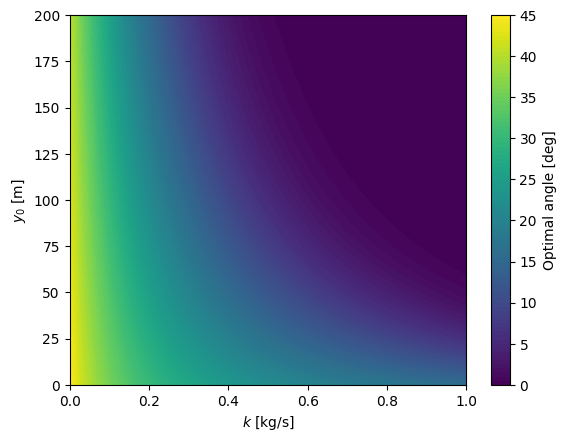

In [60]:
fig, ax = plt.subplots()

c = ax.contourf(kk, yy, alpha_opt_vals * 180 / np.pi, levels=100)
ax.set_xlabel("$k$ [kg/s]")
ax.set_ylabel("$y_0$ [m]")

cbar = fig.colorbar(c)
cbar.set_label("Optimal angle [deg]")



## Quadratic response to air resistance

$$F_{\text{res}} = \frac{1}{2} \rho C S v^2 = k v^2$$

$$
C \approx 0.5, m = 1\,\text{kg}, \rho = 1,3\, \mathrm{kg/m^3}, S = 0.01 \mathrm{m^2}
$$

$$
\frac{1}{2} \rho C S = k \approx 0.0065 \,\mathrm{kg/m}
$$

$C$ ... koule

In [61]:
k_air = 0.0065

### SymPy

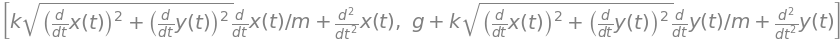

In [62]:
v = sy.sqrt(x(t).diff(t)**2 + y(t).diff(t)**2)
eq_x = x(t).diff((t ,2)) + (k / m) * v * x(t).diff(t)
eq_y = y(t).diff((t, 2)) + (k / m) * v * y(t).diff(t) + g

system = [eq_x, eq_y]

system


In [67]:
# sy.dsolve(system, ics = ics, t=t)


TypeError: BaseException.with_traceback() takes exactly one argument (0 given)

In [ ]:
# dsolve_system(system, ics = ics, t=t)

Tak tady jsme velice rychle narazili na limity analytického řešení. Dále se tedy budeme věnovat pouze numerickému řešení.

### Numerické řešení pomocí SciPy 

\begin{align}
\dot x &= v_x \\
\dot v_x &= -\frac{k}{m} v v_x \\
\dot y &= v_y \\
\dot v_y &= -g - \frac{k}{m} v v_y
\end{align}

kde $v = \sqrt{v_x^2 + v_y^2}$.

Tedy už pojedeme rychleji.


In [68]:
def solve_balistic_curve(alpha, v0, y0, k, m, t_eval = None):
    """Numerické řešení balistické křivky s kvadratickým odporem vzduchu.
    
    Args:
        alpha (float): Úhel výstřelu [rad]
        v0 (float): Počáteční rychlost [m/s]
        y0 (float): Počáteční výška [m]
        k (float): Koeficient odporu vzduchu [kg/m], $k = \frac{1}{2} \rho C S$
        m (float): Hmotnost tělesa [kg]
        t_eval (array): Hodnoty času, pro které chceme řešení, default None.
    """
    
    def rhs(t, y):
        x, v_x, y, v_y = y
        v = np.sqrt(v_x**2 + v_y**2)
        dvx_dt = -k / m * v * v_x
        dvy_dt = -g_ - k / m * v * v_y
        return [v_x, dvx_dt, v_y, dvy_dt]
    
    y_init = [0, v0 * np.cos(alpha), y0, v0 * np.sin(alpha)]
    sol = solve_ivp(rhs, [0, 1000], y_init, events=hit_ground_event, t_eval=t_eval)
    #                        ^^^ vyšší hodnota maximalního času, abychom se vyhnuli problémům s detekcí dopadu na zem
    
    return sol

In [69]:
sol = solve_balistic_curve(np.pi / 4, 100, 0, 0.1, 1)
sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  1.414e-05 ...  3.116e+00  3.377e+00]
        y: [[ 0.000e+00  9.999e-04 ...  2.550e+01  2.583e+01]
            [ 7.071e+01  7.070e+01 ...  1.441e+00  1.123e+00]
            [ 0.000e+00  9.999e-04 ...  2.471e+00  5.329e-15]
            [ 7.071e+01  7.070e+01 ... -9.324e+00 -9.541e+00]]
      sol: None
 t_events: [array([ 3.377e+00])]
 y_events: [array([[ 2.583e+01,  1.123e+00,  5.329e-15, -9.541e+00]])]
     nfev: 92
     njev: 0
      nlu: 0

In [70]:
# Nyní si definujeme pomocné funkce:

def balistic_curve_trajectory(alpha, v0, y0, k, m, t_eval = None):
    sol = solve_balistic_curve(alpha, v0, y0, k, m, t_eval = t_eval)
    return sol.y[0], sol.y[2]

def find_optimal_angle_balistic_curve(v0, y0, k, m):
    min_func = lambda alpha: -solve_balistic_curve(alpha, v0, y0, k, m).y_events[0][0][0]
    res = minimize_scalar(min_func, bounds=(0, np.pi / 2), method="bounded")
    return res.x



In [71]:
find_optimal_angle_balistic_curve(100, 0, 0.1, 1) * 180 / np.pi

#### Vizualizace optimalního úhlu výstřelu pro různé hodnoty $y_0$ a $k$.

In [72]:
# Vektorizujeme funkci pro rychlejší výpočty
find_optimal_angle_balistic_curve = np.vectorize(find_optimal_angle_balistic_curve)



##### $y_0 = 0$

In [73]:
k_vals = np.linspace(0, 0.1, 100)

alpha_opt_vals = find_optimal_angle_balistic_curve(100, 0, k_vals, 1)

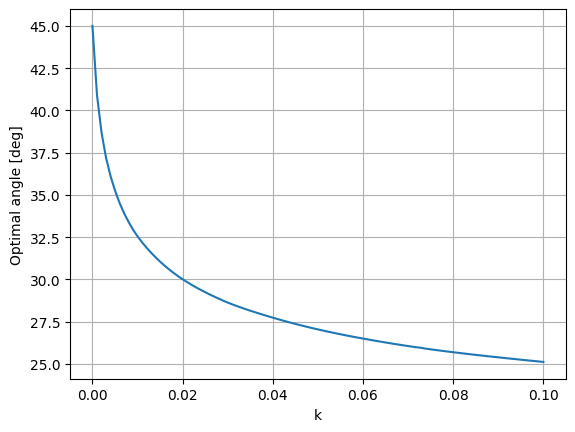

In [74]:
fig, ax = plt.subplots()

ax.plot(k_vals, alpha_opt_vals * 180 / np.pi)
ax.set_xlabel("k")
ax.set_ylabel("Optimal angle [deg]")
ax.grid(True)


##### $y_0 \neq 0$

In [75]:
%%time
k_vals = np.linspace(0, 0.2, 35)
y0_vals = np.linspace(0, 200, 30)

yy, kk = np.meshgrid(y0_vals, k_vals)

alpha_opt_vals = find_optimal_angle_balistic_curve(100, yy, kk, 1)

CPU times: user 11.8 s, sys: 45 ms, total: 11.8 s
Wall time: 11.8 s


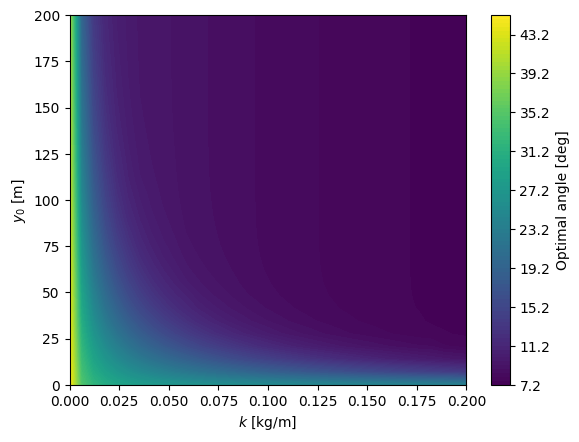

In [76]:
fig, ax = plt.subplots()

c = ax.contourf(kk, yy, alpha_opt_vals * 180 / np.pi, levels=100)
ax.set_xlabel("$k$ [kg/m]")
ax.set_ylabel("$y_0$ [m]")
cbar = fig.colorbar(c)
cbar.set_label("Optimal angle [deg]")



##### Bonus: porovnaní lineární a kvaratické odezvy na odpor vzduchu

In [77]:
%%time
k_vals = np.linspace(0, 0.15, 35)
y0_vals = np.linspace(0, 200, 30)

yy, kk = np.meshgrid(y0_vals, k_vals)

alpha_opt_vals_lin = find_optimal_angle_lin_response(100, yy, kk, 1)
alpha_opt_vals_quad = find_optimal_angle_balistic_curve(100, yy, kk, 1)

CPU times: user 15.6 s, sys: 3.43 ms, total: 15.6 s
Wall time: 15.7 s


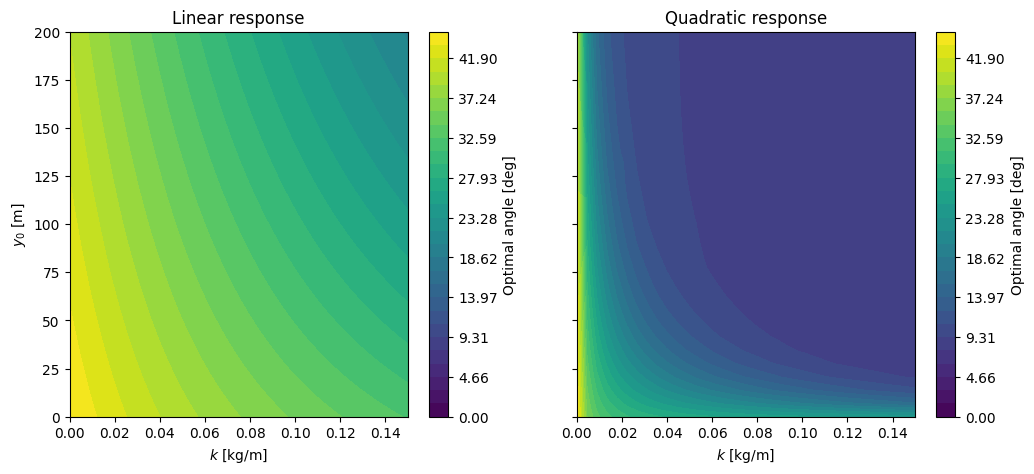

In [78]:

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

c = ax[0].contourf(kk, yy, alpha_opt_vals_lin * 180 / np.pi, levels=np.linspace(0, 45, 30, endpoint=True))
ax[0].set_xlabel("$k$ [kg/m]")
ax[0].set_ylabel("$y_0$ [m]")
ax[0].set_title("Linear response")
cbar = fig.colorbar(c, ax=ax[0])
cbar.set_label("Optimal angle [deg]")
c = ax[1].contourf(kk, yy, alpha_opt_vals_quad * 180 / np.pi, levels=np.linspace(0, 45, 30, endpoint=True))
ax[1].set_xlabel("$k$ [kg/m]")
ax[1].set_title("Quadratic response")
cbar = fig.colorbar(c, ax=ax[1])
cbar.set_label("Optimal angle [deg]")




#### Porovnání trajektorií pro různé úhly výstřelu

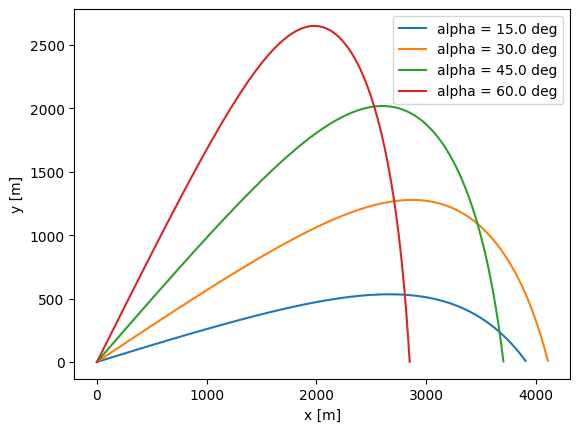

In [79]:
alphas = [np.pi / 12, np.pi / 6, np.pi / 4, np.pi / 3]
t_vals = np.linspace(0, 100, 1000)

v0_ = 1000

fig, ax = plt.subplots()

for alpha_ in alphas:
    x_vals, y_vals = balistic_curve_trajectory(alpha_, v0_, y0 = 0, k = k_air, m = m_, t_eval = t_vals)
    ax.plot(x_vals, y_vals, label=f"alpha = {alpha_ * 180 / np.pi:.1f} deg")
    
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.legend(f"k = {k_air}, m = {m_}, v0 = {v0_}, y0 = {y0_}")
ax.legend()

## Bonus: porovnaní různých modelů odporu vzduchu

### $y_0 = 0, \alpha = 30$

In [80]:
# Pro připomenutí:
k_, k_air


In [81]:
alpha_ = np.pi / 6
v0_ = 100
y0_ = 0

In [82]:
t_vals = np.linspace(0, 50, 200)

x_vals_noair = funx_noair_allargs(t_vals, v0_, alpha_, y0_)
y_vals_noair = funy_noair_allargs(t_vals, v0_, alpha_, y0_)

x_vals_lin = funx_lin_allargs(t_vals, v0_, alpha_, y0_, k_, m_)
y_vals_lin = funy_lin_allargs(t_vals, v0_, alpha_, y0_, k_, m_)

x_vals_quad, y_vals_quad = balistic_curve_trajectory(alpha_, v0_, y0_, k_air, m_, t_eval = t_vals)


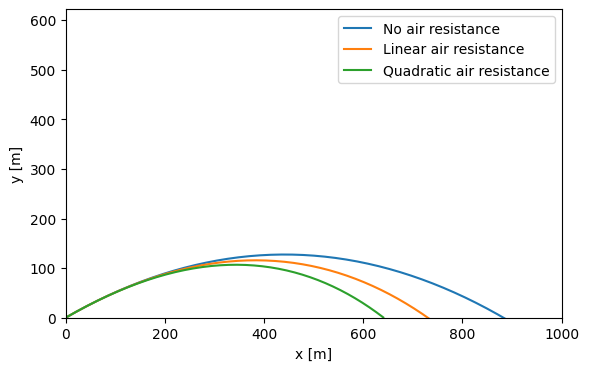

In [83]:
fig, ax = plt.subplots()

ax.plot(x_vals_noair, y_vals_noair, "-", label="No air resistance")
ax.plot(x_vals_lin, y_vals_lin, "-", label="Linear air resistance")
ax.plot(x_vals_quad, y_vals_quad, "-", label="Quadratic air resistance")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_ylim(0, None)
ax.set_xlim(0, 1000)
ax.set_aspect("equal")

ax.legend()


## Some visualizations with widgets

In [84]:
from ipywidgets import *
# %matplotlib inline
%matplotlib widget

In [85]:


t_vals = np.linspace(0, 100, 300)

# Pamatujete, tohle je numerické vyhodnocení analytického řešení
# 
x_vals_noair = funx_noair_allargs(t_vals, v0_, alpha_, y0_)
y_vals_noair = funy_noair_allargs(t_vals, v0_, alpha_, y0_)
mask = y_vals_noair >= 0
x_vals_noair = x_vals_noair[mask]
y_vals_noair = y_vals_noair[mask]

x_vals_lin = funx_lin_allargs(t_vals, v0_, alpha_, y0_, 0.1, 1)
y_vals_lin = funy_lin_allargs(t_vals, v0_, alpha_, y0_, 0.1, 1)
mask = y_vals_lin >= 0
x_vals_lin = x_vals_lin[mask]
y_vals_lin = y_vals_lin[mask]

x_vals_quad, y_vals_quad = balistic_curve_trajectory(alpha_, v0_, y0_, 0.0065, 1, t_eval = t_vals)


fig, ax = plt.subplots()

line_noair = ax.plot(x_vals_noair, y_vals_noair, "-", label="No air resistance")
line_lin = ax.plot(x_vals_lin, y_vals_lin, "-", label="Linear air resistance")
line_quad = ax.plot(x_vals_quad, y_vals_quad, "-", label="Quadratic air resistance")

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)
ax.set_aspect("equal")
# position legend to the right above the plot
ax.legend(bbox_to_anchor=(1, 1.05), loc='lower right', borderaxespad=0.0)
# ax.set_xlim(0, 300)
# ax.set_ylim(0, 150)

def update(v0 = v0_, alpha = alpha_, y0 = y0_, k = k_, k_air = k_air, m = m_):
    x_vals_noair = funx_noair_allargs(t_vals, v0, alpha, y0)
    y_vals_noair = funy_noair_allargs(t_vals, v0, alpha, y0)
    mask = y_vals_noair >= 0
    x_vals_noair = x_vals_noair[mask]
    y_vals_noair = y_vals_noair[mask]

    x_vals_lin = funx_lin_allargs(t_vals, v0, alpha, y0, k, m)
    y_vals_lin = funy_lin_allargs(t_vals, v0, alpha, y0, k, m)
    mask = y_vals_lin >= 0
    x_vals_lin = x_vals_lin[mask]
    y_vals_lin = y_vals_lin[mask]

    x_vals_quad, y_vals_quad = balistic_curve_trajectory(alpha, v0, y0, k_air, m, t_eval = t_vals)
    
    line_noair[0].set_data(x_vals_noair, y_vals_noair)
    line_lin[0].set_data(x_vals_lin, y_vals_lin)
    line_quad[0].set_data(x_vals_quad, y_vals_quad)
    
    xmax = max(x_vals_noair.max(), x_vals_lin.max(), x_vals_quad.max())
    ymax = max(y_vals_noair.max(), y_vals_lin.max(), y_vals_quad.max())
    
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    plt.show()
    # ax.legend()
    
    fig.canvas.draw_idle()


# def update(v0 = v0_, alpha = alpha_, y0 = y0_, k = k_, k_air = k_air, m = 1):
#     
#     
#         fig.canvas.draw_idle()

interact(update, v0 = (20, 1000, 1), alpha = (0, np.pi / 2, 0.01), y0 = (0, 200, 1), k = (0, 1, 0.01), k_air = (0, 0.1, 0.001), m = (0, 200, 0.1))

interactive(children=(IntSlider(value=100, description='v0', max=1000, min=20), FloatSlider(value=0.5235987755…

<function __main__.update(v0=100, alpha=0.5235987755982988, y0=0, k=0.3, k_air=0.0065, m=10)>